In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [22]:
plt.rcParams['figure.figsize'] = (10,10)
sns.set(rc={'figure.figsize' : (15,10)})
plt.style.use('seaborn') # seaborn 스타일로 변환
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings('ignore')

# 1. 데이터 불러오기 및 탐색

## 1-1. 데이터 불러오기('pickup_datetime' 컬럼을 datetime으로 parsing)

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## 1-2. 데이터셋의 정보 및 결측치 확인

In [10]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1           -73.982           40.768            -73.965   
1                1           -73.980           40.739            -73.999   
2                1           -73.979           40.764            -74.005   
3                1           -74.010           40.720            -74.012   
4                1           -73.973           40.793            -73.973   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0            40.766                  N            455  
1            40.731                  N            663  
2            40.710                  N           2124  
3            40.707                  N            429  
4            40.783                  N            435

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [9]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## 1-3. 종속변수 산점도 및 히스토그램 그려보기

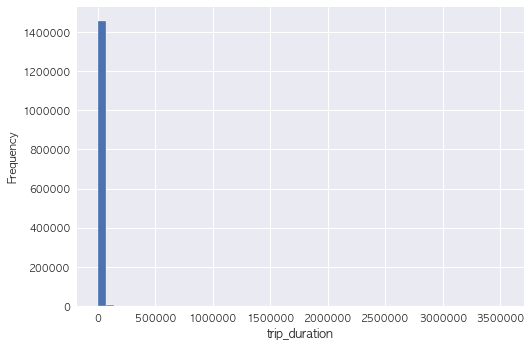

In [31]:
# 한 쪽으로 매우 치우쳐 있음
train['trip_duration'].plot.hist(bins = 50)
plt.xlabel('trip_duration', fontsize = 12)
plt.show()

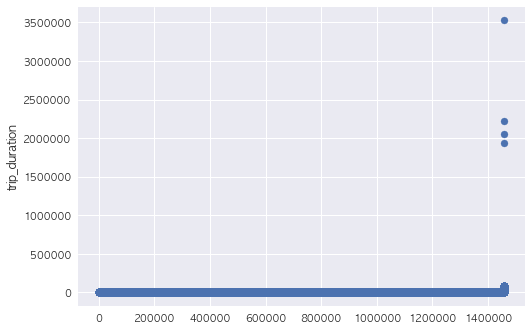

In [33]:
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration.values))
plt.ylabel('trip_duration', fontsize = 12)
plt.show()

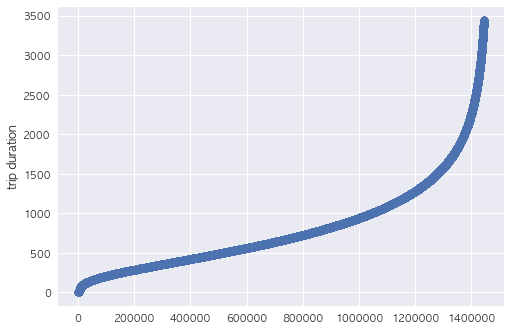

In [38]:
# 99%까지의 trip_duration을 가지고 그린 scatter
# trip_duration의 이상치 판단은 거리 비교를 통해 할 예정
temp = train[train['trip_duration'] < train.trip_duration.quantile(0.99)]
plt.scatter(range(temp.shape[0]), np.sort(temp.trip_duration.values))
plt.ylabel('trip duration', fontsize=12)
plt.show()

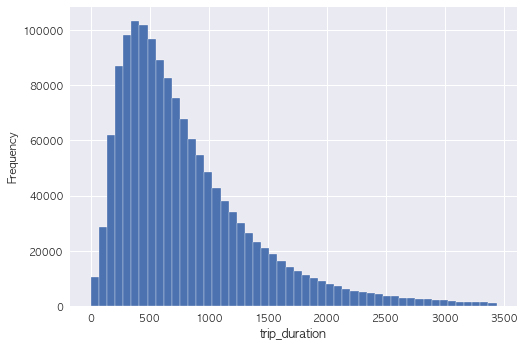

In [37]:
temp['trip_duration'].plot.hist(bins = 50)
plt.xlabel('trip_duration', fontsize = 12)
plt.show()

## 1-4. 종속변수 로그 변환 후 히스토그램

In [39]:
train['log_trip_duration'] = train['trip_duration'].apply(lambda x : np.log(x + 1))

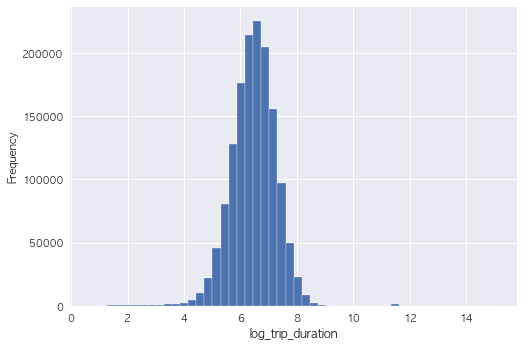

In [40]:
train['log_trip_duration'].plot.hist(bins = 50)
plt.xlabel('log_trip_duration', fontsize = 12)
plt.show()

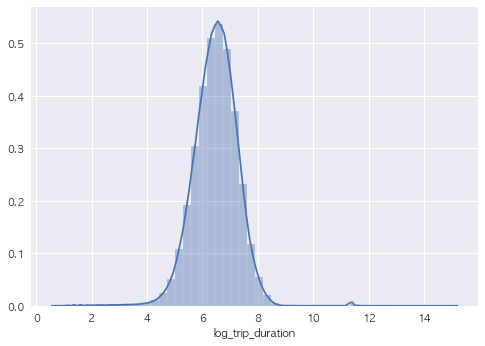

In [41]:
sns.distplot(train["log_trip_duration"], bins =50)
plt.show()

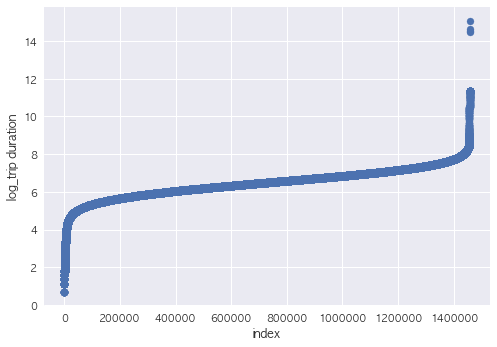

In [42]:
plt.scatter(range(train.shape[0]), np.sort(train.log_trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('log_trip duration', fontsize=12)
plt.show()

## 1-5. 날짜 변환

In [44]:
import time
from datetime import datetime

In [45]:
# datetime 형식으로 바꿔주기
train['pickup_datetime'] = train['pickup_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['dropoff_datetime'] = train['dropoff_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test['pickup_datetime'] = test['pickup_datetime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [49]:
# 택시 탄 시점의 시간을 모두 구분 (초 제외)
def changeDate(df):
    df['pickup_month'] = df['pickup_datetime'].dt.month # 월
    df['pickup_day'] = df['pickup_datetime'].dt.day # 일자
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday # 요일
    df['pickup_hour'] = df['pickup_datetime'].dt.hour # 시간
    df['pickup_minute'] = df['pickup_datetime'].dt.minute # 분
#     df['pickup_second'] = df['pickup_datetime'].dt.second # 초
    return df

In [50]:
train = changeDate(train)
test = changeDate(test)

In [53]:
# 시간별 택시 탑승

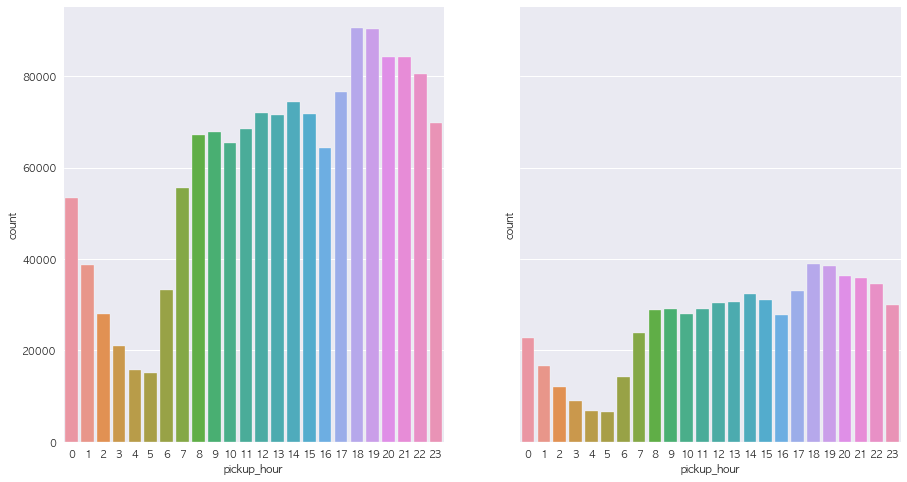

In [63]:
f, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.countplot(train['pickup_hour'], ax = axes[0])
sns.countplot(test['pickup_hour'], ax = axes[1])
plt.show()

In [19]:
# 일자별 택시 탑승 인원 plot

In [51]:
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

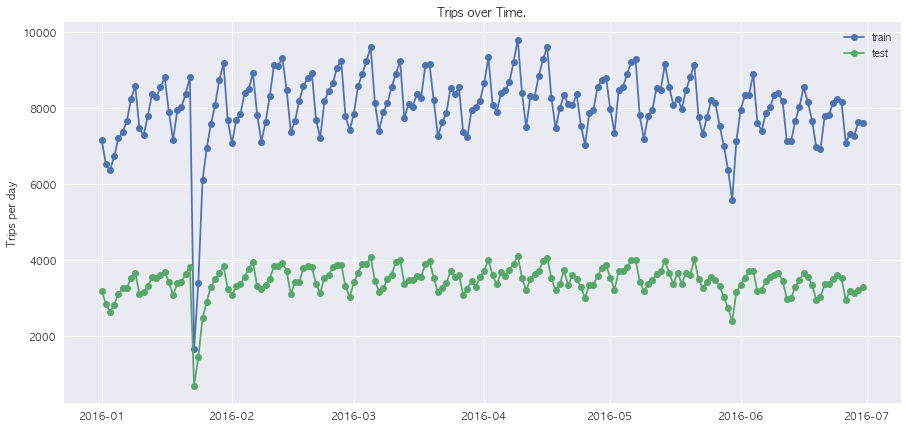

In [52]:
plt.figure(figsize = (15, 7))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips per day')
plt.show()

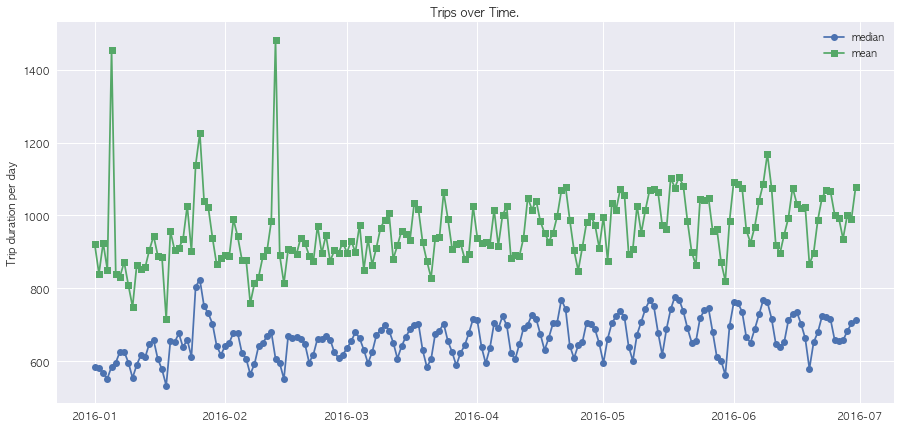

In [64]:
plt.figure(figsize = (15, 7))
plt.plot(train.groupby('pickup_date')[['trip_duration']].median(), 'o-', label='train')
plt.plot(train.groupby('pickup_date')[['trip_duration']].mean(), 's-', label='train')
plt.title('Trips over Time.')
plt.legend(['median', 'mean'])
plt.ylabel('Trip duration per day')
plt.show()

## 1-6.'store_and_fwd_flag' 인코딩

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server

- Y=store and forward
- N=not a store and forward trip

In [65]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [66]:
# Y는 1로, N은 0으로
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].apply(lambda x : 1 if x == 'Y' else 0)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].apply(lambda x : 1 if x == 'Y' else 0)

# 1-7. passenger_count

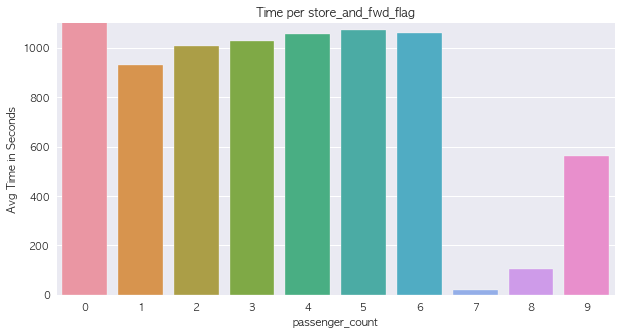

In [67]:
# 승객이 0명인 경우 60개 -> 승객 1명으로 변경
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(10,5))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.ylabel('Avg Time in Seconds')
sns.barplot(pc.index,pc.values)
plt.show()

In [68]:
train.loc[train['passenger_count'] == 0, 'passenger_count'] = 1
test.loc[test['passenger_count'] == 0, 'passenger_count'] = 1

# 2. 데이터 시각화

## 2-1. 'pickup_latitude', 'pickup_longitude'변수 사용하여 geological map그려보기(folium 사용)

In [27]:
import folium

In [28]:
map_osm = folium.Map(location = [40.76793671, -73.98215485], zoom_start = 13)

In [29]:
for lat, lon in train[['pickup_latitude', 'pickup_longitude']].values[:10000]:
    folium.CircleMarker([lat, lon], radius = 1).add_to(map_osm)
    
map_osm

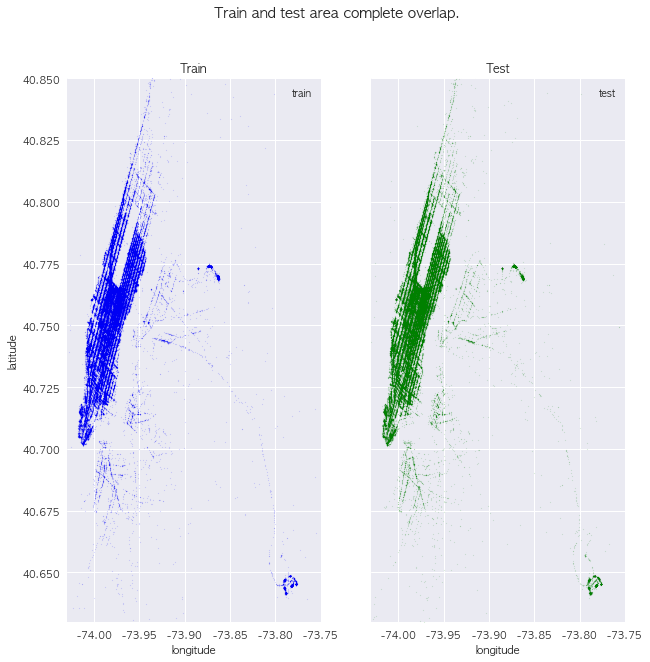

In [69]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize = (10, 10))
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_title('Train')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_title('Test')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [71]:
coord_pickup = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,                  
                          test[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((train[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

In [73]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data

In [76]:
from sklearn.cluster import MiniBatchKMeans

In [77]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (train, test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

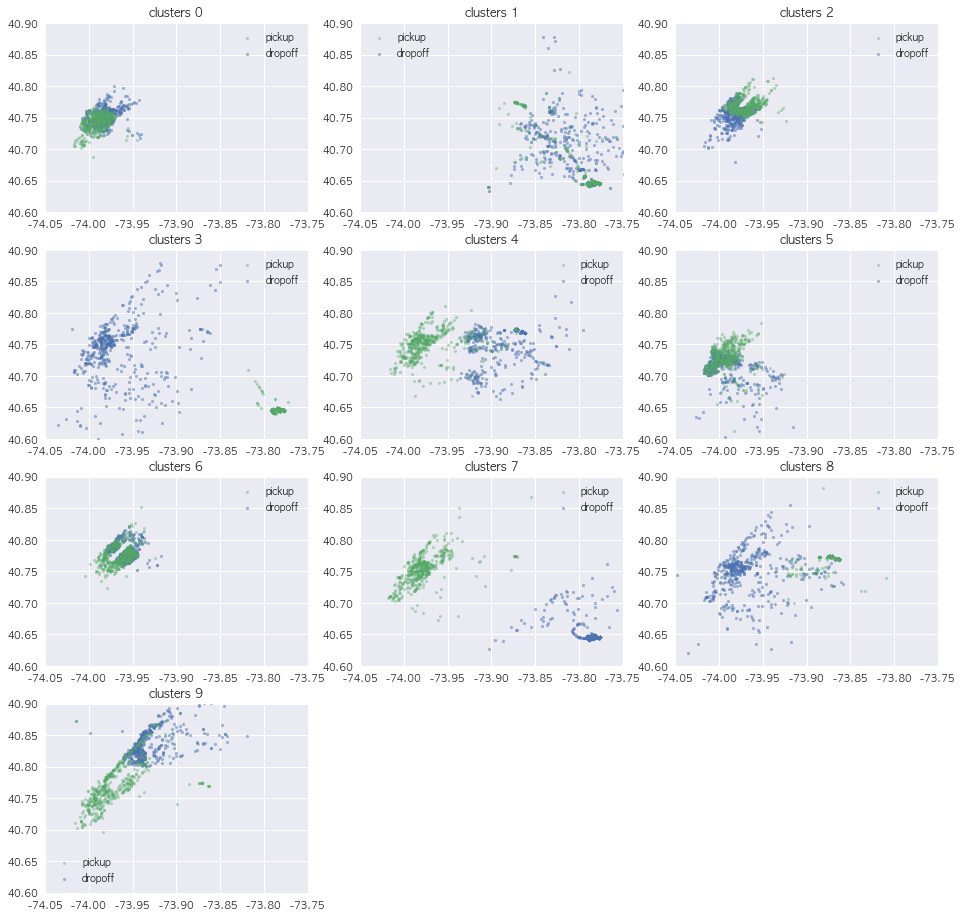

In [80]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = train[train.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

## 2-2. ‘day of week’변수 요일별 빈도수 그래프 그려보기

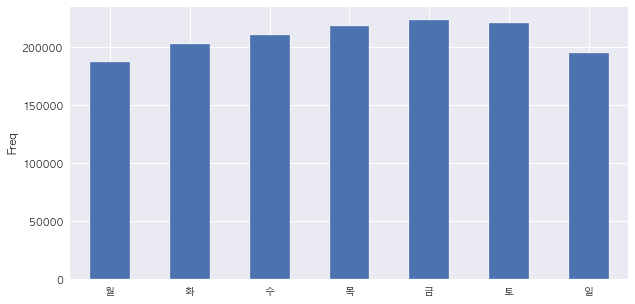

In [81]:
train['pickup_weekday'].value_counts().sort_index().plot.bar(rot = 0, figsize = (10, 5))
plt.xticks(range(0,7), ['월', '화', '수', '목', '금', '토', '일'])
plt.ylabel('Freq')
plt.show()

## 2-3. ‘store_and_fwd_flag’변수 density 그래프 그려보기(한 그래프에 그리기)

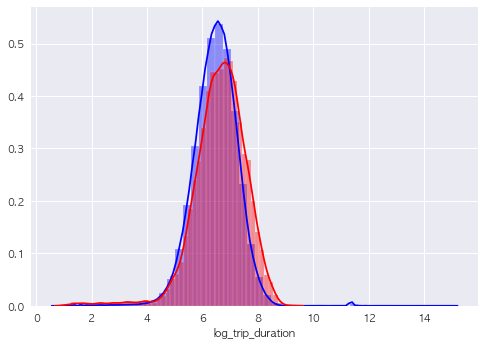

In [82]:
sns.distplot(train.loc[train['store_and_fwd_flag'] == 0, 'log_trip_duration'], color = 'blue')
sns.distplot(train.loc[train['store_and_fwd_flag'] == 1, 'log_trip_duration'], color = 'red')

## 2-4. x="dayofweek", y="trip_duration", hue="vendor_id"로 지정하여 boxplot그려보고 해석하기

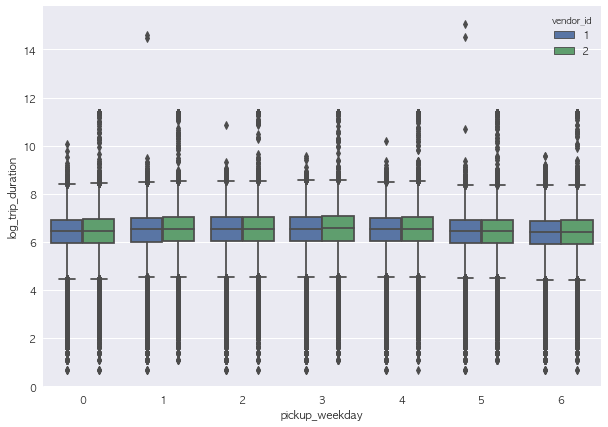

In [83]:
plt.figure(figsize = (10, 7))
sns.boxplot(data = train, x = 'pickup_weekday', y = 'log_trip_duration', hue = 'vendor_id')
plt.show()

# 3. 피처엔지니어링

## 3-1. KNYC_Metars.csv파일 불러와서 날씨 변수 추가('Time' 컬럼을 datetime으로 parsing)

In [84]:
meta = pd.read_csv('KNYC_Metars.csv')

In [85]:
meta['Time'] = meta['Time'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [86]:
meta.head()

Time  Temp.  Windchill  Heat Index  Humidity  Pressure  \
0 2015-12-31 02:00:00  7.800      7.100         nan     0.890  1017.000   
1 2015-12-31 03:00:00  7.200      5.900         nan     0.900  1016.500   
2 2015-12-31 04:00:00  7.200        nan         nan     0.900  1016.700   
3 2015-12-31 05:00:00  7.200      5.900         nan     0.860  1015.900   
4 2015-12-31 06:00:00  7.200      6.400         nan     0.900  1016.200   

   Dew Point  Visibility  Wind Dir  Wind Speed  Gust Speed  Precip Events  \
0      6.100       8.000       NNE       5.600       0.000   0.800   None   
1      5.600      12.900  Variable       7.400       0.000   0.300   None   
2      5.600      12.900      Calm       0.000       0.000   0.000   None   
3      5.000      14.500        NW       7.400       0.000   0.000   None   
4      5.600      11.300      West       5.600       0.000   0.000   None   

  Conditions  
0   Overcast  
1   Overcast  
2   Overcast  
3   Overcast  
4   Overcast

In [87]:
### ‘Events’변수의 유일한 값 구하기
meta['Events'].value_counts()

None              8332
Rain               377
Snow                51
Fog\n\t,\nSnow      23
Fog                  2
Fog\n\t,\nRain       2
Name: Events, dtype: int64

In [88]:
### 'snow' 변수 만들기
meta['snow'] = meta['Events'].apply(lambda x: 1 if x == 'Fog\n\t,\nSnow' or x == 'Snow' else 0)

In [89]:
meta = meta.drop('Events', axis = 1)

In [90]:
### 날짜 변수 만들기
meta['pickup_month'] = meta['Time'].dt.month
meta['pickup_day'] = meta['Time'].dt.day
meta['pickup_hour'] = meta['Time'].dt.hour

In [91]:
### 2016년도만 불러오기
meta = meta.loc[meta['Time'].dt.year == 2016]

In [92]:
meta = meta.reset_index(drop = True)

In [93]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8739 entries, 0 to 8738
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          8739 non-null   datetime64[ns]
 1   Temp.         8739 non-null   float64       
 2   Windchill     2267 non-null   float64       
 3   Heat Index    815 non-null    float64       
 4   Humidity      8739 non-null   float64       
 5   Pressure      8508 non-null   float64       
 6   Dew Point     8739 non-null   float64       
 7   Visibility    8502 non-null   float64       
 8   Wind Dir      8739 non-null   object        
 9   Wind Speed    8739 non-null   float64       
 10  Gust Speed    8739 non-null   float64       
 11  Precip        8739 non-null   float64       
 12  Conditions    8739 non-null   object        
 13  snow          8739 non-null   int64         
 14  pickup_month  8739 non-null   int64         
 15  pickup_day    8739 non-null   int64   

In [94]:
# 기후 상태 범주화
meta['Conditions'].value_counts()

Clear                  4536
Overcast               1828
Mostly Cloudy           608
Partly Cloudy           510
Scattered Clouds        328
Unknown                 301
Light Rain              292
Haze                    173
Rain                     62
Light Snow               46
Snow                     23
Heavy Rain               22
Heavy Snow                5
Light Freezing Rain       3
Fog                       1
Light Freezing Fog        1
Name: Conditions, dtype: int64

In [95]:
def weather(x):
    if x in ['Overcast', 'Mostly Cloudy', 'Partly Cloudy', 'Scattered Clouds']:
        v = 'cloudy'
    elif x in ['Light Rain', 'Rain', 'Heavy Rain', 'Light Freezing Rain']:
        v = 'rainy'
    elif x in ['Light Snow', 'Snow', 'Heavy Snow']:
        v = 'snowy'
    elif x in ['Light Freezing Fog', 'Haze', 'Fog']:
        v = 'foggy'
    elif x == 'Clear':
        v = 'clear'
    else:
        v = 'unknown'
    return v

In [96]:
meta['Conditions'] = meta['Conditions'].map(lambda x : weather(x))

In [97]:
# Null의 비율이 높은 'Windchill' 과 'Heat Index' 제거
(meta.isnull()).sum() / meta.shape[0]

Time           0.000
Temp.          0.000
Windchill      0.741
Heat Index     0.907
Humidity       0.000
Pressure       0.026
Dew Point      0.000
Visibility     0.027
Wind Dir       0.000
Wind Speed     0.000
Gust Speed     0.000
Precip         0.000
Conditions     0.000
snow           0.000
pickup_month   0.000
pickup_day     0.000
pickup_hour    0.000
dtype: float64

In [98]:
meta = meta.drop(['Windchill', 'Heat Index'], axis = 1)

In [99]:
### Visibility 채우기

In [100]:
temp = meta.groupby(meta['Time'].dt.date)['Visibility'].mean().reset_index()

In [101]:
temp

Time  Visibility
0    2016-01-01      16.100
1    2016-01-02      16.100
2    2016-01-03      16.100
3    2016-01-04      16.100
4    2016-01-05      16.100
..          ...         ...
361  2016-12-27      15.900
362  2016-12-28      16.100
363  2016-12-29      12.908
364  2016-12-30      16.033
365  2016-12-31      16.100

[366 rows x 2 columns]

In [102]:
meta['date'] = meta['Time'].dt.date

In [103]:
visi = []
for dt, v in meta[['date', 'Visibility']].values:
    try:
        int(v)
    except:
        v = temp.loc[temp['Time'] == dt, 'Visibility']
    visi.append(v)

In [104]:
meta['Visibility'] = visi

In [105]:
meta = meta[['Humidity', 'Pressure', 'Dew Point', 'Visibility', 'Wind Speed', 'Conditions', 'snow', 'pickup_month', 'pickup_day', 'pickup_hour']]

In [106]:
meta.isnull().sum()

Humidity          0
Pressure        231
Dew Point         0
Visibility        0
Wind Speed        0
Conditions        0
snow              0
pickup_month      0
pickup_day        0
pickup_hour       0
dtype: int64

In [110]:
train = train.merge(meta, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')
test = test.merge(meta, on = ['pickup_month', 'pickup_day', 'pickup_hour'], how = 'left')

In [111]:
train.shape, test.shape

((1458644, 26), (625134, 23))

## 3-2. Haversine distance, Manhattan distance Bearing 거리 계산법을 사용하여 거리 계산

In [112]:
# 거리 계산 방법
import numbers
import math
from tqdm import tqdm

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

In [113]:
total = []
for args in tqdm(train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values):
    x_lon, x_lat = args[:2]
    y_lon, y_lat = args[2:]
    
    dis = GeoUtil.get_harversion_distance(x_lon, x_lat, y_lon, y_lat)
#     dis = GeoUtil.get_harversion_distance(x_lat, x_lon, y_lat, y_lon)
    total.append(dis)

100%|██████████| 1458644/1458644 [00:15<00:00, 96163.85it/s]


In [114]:
train['distance'] = total

In [115]:
total = []
for args in tqdm(test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].values):
    x_lon, x_lat = args[:2]
    y_lon, y_lat = args[2:]
    
    dis = GeoUtil.get_harversion_distance(x_lon, x_lat, y_lon, y_lat)
#     dis = GeoUtil.get_harversion_distance(x_lat, x_lon, y_lat, y_lon)
    total.append(dis)

100%|██████████| 625134/625134 [00:06<00:00, 94812.95it/s]


In [116]:
test['distance'] = total

In [51]:
## 3-2. distance가 0인 것 -> 삭제

In [118]:
train[train['distance'] == 0].shape

(5897, 27)

In [119]:
train = train[train['distance'] != 0]

## 3-. 속도 구하기

In [120]:
train['speed'] = (train['distance'] / (train['trip_duration'] / 3600))

In [122]:
# 말도안되게 속력이 높거나 낮은 경우
train.loc[(train['speed'] > 150) | (train['speed'] <= 0.5), ['trip_duration', 'distance', 'speed']].sort_values('speed')

trip_duration  distance    speed
822586           86322     0.001    0.000
780672           81205     0.001    0.000
551398           82817     0.001    0.000
62744            85901     0.001    0.000
1239221          72792     0.003    0.000
...                ...       ...      ...
377068             282   320.126 4086.712
974378             611   891.214 5251.016
184925             792  1240.909 5640.494
910072             303   578.843 6877.340
1176337              7    18.034 9274.834

[5555 rows x 3 columns]

In [123]:
train = train[(train['speed'] <= 150) | (train['speed'] >= 0.5)]

## 3-3. 소수 2번째까지 보이게 하기

In [149]:
def roundDF(df):
    columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance']
    for c in columns:
        df[c] = df[c].apply(lambda x : round(x, 2))
    return df

In [150]:
train = roundDF(train)
test = roundDF(test)

## 3-4. 'pickup_datetime', 'dropoff_datetime'컬럼 제거하기

In [126]:
train = train.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_date', 'speed'], axis = 1)
test = test.drop(['pickup_datetime', 'pickup_date'], axis = 1)

## 3-5. feature 생성

In [127]:
def divideT(x):
    if x >= 0 and x < 7:
        v = '새벽'
    elif x >= 7 and x < 12:
        v = '아침'
    elif x > 12 and x <= 18:
        v = '오후'
    else:
        v = '저녁'
    return v

In [128]:
# 탑승 시간대 생성
train['pickup_time'] = train['pickup_hour'].map(lambda x : divideT(x))
test['pickup_time'] = test['pickup_hour'].map(lambda x : divideT(x))

In [157]:
# 탑승 평일/주말 생성

In [131]:
train['pickup_weekday'].value_counts()

4    222614
5    220006
3    217656
2    209297
1    201931
6    194562
0    186681
Name: pickup_weekday, dtype: int64

In [132]:
train['weekend'] = train['pickup_weekday'].apply(lambda x : 0 if x >= 0 and x < 5 else 1)

In [133]:
test['weekend'] = test['pickup_weekday'].apply(lambda x : 0 if x >= 0 and x < 5 else 1)

## 3-6. 상관관계 확인

In [136]:
train.shape, test.shape

((1452747, 26), (625134, 24))

In [142]:
columns = list(train.isnull().sum().sort_values().index[1:19])

In [143]:
columns.remove('log_trip_duration')
columns.remove('trip_duration')

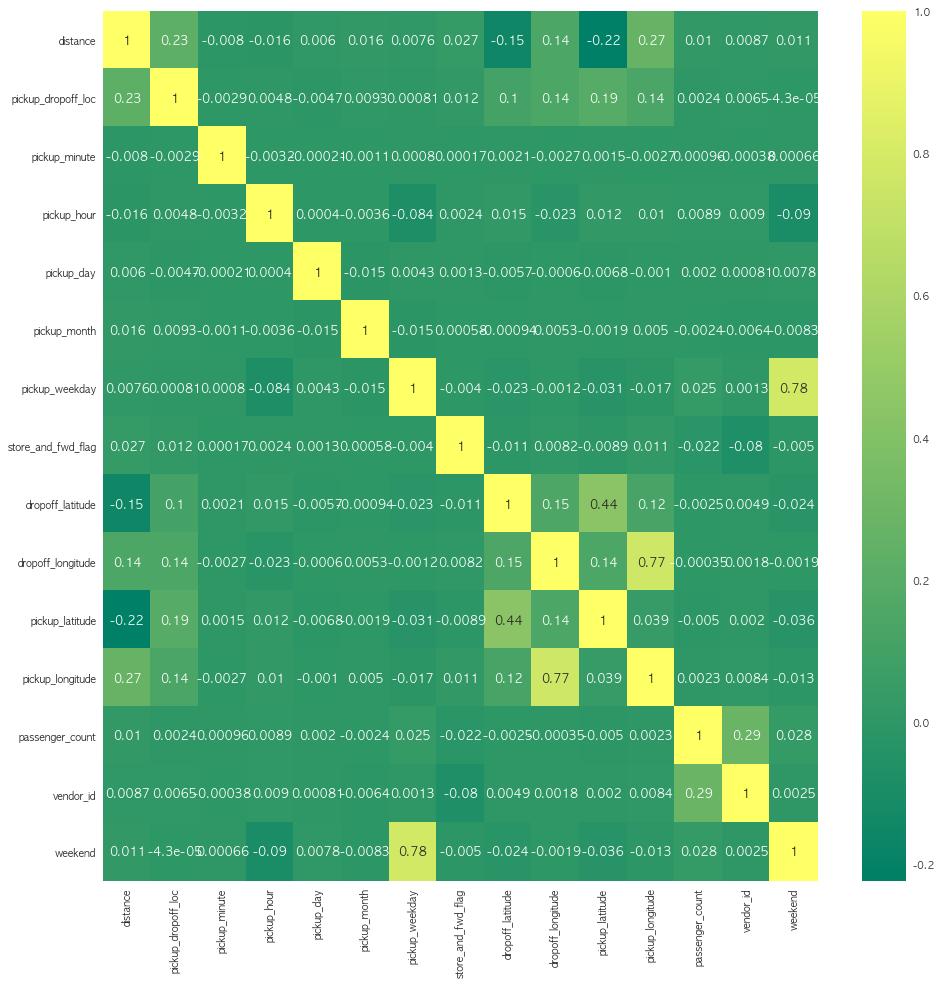

In [145]:
### 상관관계 확인
plt.figure(figsize = (16,16))
sns.heatmap(train[columns].corr(), annot = True, cmap = 'summer')
plt.show()

# 4. 모델링

In [147]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

## 4-0. train, valid split 진행

In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452747 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1452747 non-null  object 
 1   vendor_id           1452747 non-null  int64  
 2   passenger_count     1452747 non-null  int64  
 3   pickup_longitude    1452747 non-null  float64
 4   pickup_latitude     1452747 non-null  float64
 5   dropoff_longitude   1452747 non-null  float64
 6   dropoff_latitude    1452747 non-null  float64
 7   store_and_fwd_flag  1452747 non-null  int64  
 8   trip_duration       1452747 non-null  int64  
 9   log_trip_duration   1452747 non-null  float64
 10  pickup_month        1452747 non-null  int64  
 11  pickup_day          1452747 non-null  int64  
 12  pickup_weekday      1452747 non-null  int64  
 13  pickup_hour         1452747 non-null  int64  
 14  pickup_minute       1452747 non-null  int64  
 15  pickup_dropoff_

In [184]:
train = train.fillna(0)
test = test.fillna(0)

In [164]:
train = train.drop('pickup_day', axis = 1)
test = test.drop('pickup_day', axis = 1)

In [208]:
def changeType(df):
    columns = ['vendor_id', 'pickup_month', 'pickup_weekday', 'pickup_time', 'pickup_dropoff_loc']
    for c in columns:
        df[c] = df[c].astype(str)
    df['Visibility'] = df['Visibility'].astype(float)
    return df

In [209]:
train = changeType(train)
test = changeType(test)

In [ ]:
train = train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)
test = test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)

In [211]:
tr_id = train['id']
X = train.drop(['id', 'trip_duration', 'log_trip_duration'], axis = 1)
X = pd.get_dummies(X)
y = train['trip_duration']

In [212]:
te_id = test['id']
X_t = test.drop('id', axis = 1)
X_t = pd.get_dummies(X_t)

In [213]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [214]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1162197, 48), (290550, 48), (1162197,), (290550,))

In [215]:
X_t.shape

(625134, 48)

## 4-1. RMSLE 함수 정의하기

In [216]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [217]:
from sklearn.metrics.scorer import make_scorer

RMSLE = make_scorer(rmsle_score)

## 4-2. 통계확인

In [218]:
import statsmodels.api as sm

In [240]:
model = sm.OLS(y.values, X)

In [241]:
re = model.fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     375.3
Date:                Thu, 06 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:15:05   Log-Likelihood:            -1.4497e+07
No. Observations:             1452747   AIC:                         2.899e+07
Df Residuals:                 1452706   BIC:                         2.899e+07
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
passenger_count          8.2114      3.443      2.385      0.017       1.463      14.960
store_and_fwd_flag      27.4189     58.821      0.466      0.641     -87.868     142.706
pickup_hour            -11.2874      1.791     -6.302      0.000     -14.798      -7.777
pickup_minute           -0.5180      0.250     -2.071      0.038      -1.008      -0.028
Humidity               -58.6328     40.831     -1.436      0.151    -138.661      21.395
Pressure                -0.1735      0.049     -3.550      0.000      -0.269      -0.078
Dew Point               -0.9613      0.881     -1.091      0.275      -2.688       0.766
Visibility              -0.2229      2.010     -0.111      0.912      -4.162       3.717
Wind Speed               2.4781      0.655      3.785      0.000       1.195       3.761
snow                    78.3657     25.387      3.087      0.002      28.608     128.123
distance                99.3203      1.524     65.150      0.000      96.332     102.308
weekend                 61.7304      7.517      8.212      0.000      46.998      76.463
vendor_id_1            279.6736     20.509     13.637      0.000     239.477     319.870
vendor_id_2            477.9540     20.711     23.077      0.000     437.361     518.547
pickup_month_1          83.9632     14.718      5.705      0.000      55.116     112.811
pickup_month_2          92.1643     14.155      6.511      0.000      64.421     119.908
pickup_month_3          96.6069     11.940      8.091      0.000      73.205     120.009
pickup_month_4         124.6700     11.756     10.605      0.000     101.629     147.711
pickup_month_5         161.3425     11.829     13.640      0.000     138.158     184.527
pickup_month_6         198.8807     15.215     13.071      0.000     169.059     228.702
pickup_weekday_0        40.5220     13.123      3.088      0.002      14.802      66.242
pickup_weekday_1       157.5258     12.774     12.332      0.000     132.489     182.563
pickup_weekday_2       149.8152     12.377     12.104      0.000     125.557     174.074
pickup_weekday_3       180.8868     12.488     14.484      0.000     156.410     205.364
pickup_weekday_4       167.1473     12.257     13.636      0.000     143.123     191.171
pickup_weekday_5        79.5562      8.887      8.952      0.000      62.138      96.974
pickup_weekday_6       -17.8258      9.115     -1.956      0.051     -35.691       0.039
pickup_dropoff_loc_0   -26.0197     14.407     -1.806      0.071     -54.256       2.217
pickup_dropoff_loc_1  -206.6704     54.649     -3.782      0.000    -313.781     -99.559
pickup_dropoff_loc_2   -36.6552     15.327     -2.392      0.017     -66.696      -6.615
pickup_dropoff_loc_3   490.3460     35.209     13.927      0.000     421.337     559.355
pickup_dropoff_loc_4   249.3893     24.809     10.052    

In [242]:
import xgboost as xgb

In [243]:
y_train = y_train.reset_index().drop('index',axis = 1)
y_valid = y_valid.reset_index().drop('index',axis = 1)

In [232]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

In [233]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 30,
      maximize=False, verbose_eval=1)

## 4-3. submission test

In [234]:
dtest = xgb.DMatrix(X_t)

In [235]:
pred = model.predict(dtest)

In [237]:
sub = pd.read_csv('sample_submission.csv')

In [238]:
sub['trip_duration'] = pred

In [239]:
sub.to_csv('./submission_6.csv', index = False)